**Brian Blaylock**  
**May 15, 2019**

# **Fig. 6.** Scores Spread for hour 22:00 UTC

![](./figs/Fig-06_Flash_FSS_2300-0000_UTC.png)

> FIG. 6. a) FSS (left), and POD and FAR (right) spread (standard deveation) between F01-F18 for the HRRR domain at 2200 UTC (time of day with approximate maximum lightning) between 1 May 2018 through 1 October 2018. FSS spread is for neighborhood of 120 km radius. Other footprint sizes show similar spread values (not shown). b) as in a) but for west subregion. c) as in a) but for central region. d) as in a but for east subregion.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import itertools

import sys
sys.path.append('/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3')
from BB_wx_calcs.binary_events import hit_rate, false_alarm_ratio, base_rate, forecast_rate

In [33]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [7.4,7.5]
mpl.rcParams['figure.titlesize'] = 10
mpl.rcParams['figure.titleweight'] = 'bold'
mpl.rcParams['xtick.labelsize'] = 7
mpl.rcParams['ytick.labelsize'] = 7
mpl.rcParams['axes.labelsize'] = 7
mpl.rcParams['axes.titlesize'] = 8
mpl.rcParams['lines.linewidth'] = .9
mpl.rcParams['grid.linewidth'] = .25
mpl.rcParams['grid.alpha'] = .5
#mpl.rcParams['figure.subplot.wspace'] = 0.15
#mpl.rcParams['figure.subplot.hspace'] = 0.15

mpl.rcParams['legend.fontsize'] = 7
mpl.rcParams['legend.framealpha'] = .95
mpl.rcParams['legend.labelspacing'] = 0.1
mpl.rcParams['legend.handlelength'] = 1
mpl.rcParams['legend.handletextpad'] = 0.5
mpl.rcParams['legend.borderaxespad'] = 0.3
mpl.rcParams['legend.loc'] = 'upper right'
mpl.rcParams['legend.columnspacing'] = 1.0

mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['savefig.dpi'] = 600

In [3]:
def get_contingency_table_by_hour(HOUR, MONTHS=range(5,11)):
    """
    Return a dictionary of all the data for the specified Hour from each month.
    
    Input:
        HOUR   - The hour of day, 0-23.
        MONTHS - Default is May-Oct, becuase that is what is avaialble right now.
    """
    data_dict = {}
    for DOMAIN in domains:
        data_dict[DOMAIN] = {}
        for MONTH in MONTHS:
            DIR = '/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_HRRR/GLM_and_HRRR/HRRR_GLM_contingency_table'
            FILE = '/%s/%s_2018_m%02d_h%02d.csv' % (DOMAIN, DOMAIN, MONTH, HOUR)
            data_dict[DOMAIN][MONTH] = np.genfromtxt(DIR+FILE, delimiter=',', names=True, dtype=None, encoding='UTF-8')    
    return data_dict

def get_FSS_by_hour(HOUR, radius, MONTHS=range(5,11)):
    """
    Return a dictionary of all the data for the specified Hour from each month.
    
    Input:
        HOUR   - The hour of day, 0-23.
        MONTHS - Default is May-Oct, becuase that is what is avaialble right now.
    """
    data_dict = {}
    for DOMAIN in domains:
        data_dict[DOMAIN] = {}
        for MONTH in MONTHS:
            try:
                DIR = '/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_HRRR/GLM_and_HRRR/HRRR_GLM_Fractions_Skill_Score_r%02d/' % radius
                FILE = '%s/%s_2018_m%02d_h%02d.csv' % (DOMAIN, DOMAIN, MONTH, HOUR)
                data_dict[DOMAIN][MONTH] = np.genfromtxt(DIR+FILE, delimiter=',', names=True, dtype=None, encoding='UTF-8')    
            except:
                data_dict[DOMAIN][MONTH] = np.ones_like(range(18))*np.nan
    return data_dict

In [4]:
def get_flash_count_by_hour(DOMAIN, HOUR, MONTHS=range(5,11), year=2018):
    """
    Return a dictionary of the total flash counts for a specified hour
    
    Input:
        HOUR   - The hour of day, 0-23.
        MONTHS - Default is May-Oct, becuase that is what is avaialble right now.
    """
    flashes = []
    DATES = []
    for month in MONTHS:
        FLASH_DIR = '/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_HRRR/HRRR_GLM_hit_rate_data/'
        FLASH_FILE = '/GLM_in_HRRR_%s_%s_m%02d_h%02d.csv' % (DOMAIN, year, month, HOUR)
        FILE = FLASH_DIR+FLASH_FILE
        if os.path.exists(FILE):
            data = np.genfromtxt(FILE, delimiter=',', names=True, dtype=None, encoding='UTF-8')
            flashes += list(data['GLM_FLASH_COUNT'])
            DD = np.array([])
            for D in data['DATE']:
                try:
                    DD = np.append(DD, datetime.strptime(D, '%Y-%m-%d %H:%M:%S'))
                except:
                    DD = np.append(DD, datetime.strptime(D, '%m/%d/%Y %H:%M'))
            DATES += list(DD)
    return flashes, DATES

In [5]:
def plot_add_HRRR_version_line(ax, text=True):
    ax.axvline(datetime(2018, 7, 12, 12), linestyle='--', color='k', zorder=0)
    if text:
        ax.text(datetime(2018, 7, 10), .26, 'HRRRv2', fontsize=7, ha='right')
        ax.text(datetime(2018, 7, 15), .26, 'HRRRv3', fontsize=7, ha='left')

In [198]:
def plot_flash_count(ax, HOUR, MONTHS, bar=False):
    flashes, DATES = get_flash_count_by_hour(DOMAIN, HOUR, MONTHS=MONTHS, year=2018)
    
    if bar: ax.bar(DATES, flashes, width=1, color=mpl.cm.Blues_r(0))
    else: ax.plot(DATES, flashes)
    return flashes, DATES

In [59]:
def plot_add_FSS_TS(ax, fxxs, radii, MONTHS=range(5,11), legend=True, plot=True, color='k'):
    for r in radii:
        FXX_ts = []
        for fxx in fxxs:
            if fxx == 2: color='k'
            elif fxx == 12: color='orangered'
            else: color='tab:purple'
            FSS_all = get_FSS_by_hour(HOUR, MONTHS=MONTHS, radius=r)
            FSS_fxx_ts = []
            ABCD_ts = {'A':[],
                       'B':[],
                       'C':[],
                       'D':[]}
            dates = []
            for m in MONTHS:
                FSS = FSS_all[DOMAIN][m]['F%02d_FSS' % fxx]
                FSS_fxx_ts = list(FSS_fxx_ts) + list(FSS)
                
                for i in ['A', 'B', 'C', 'D']:
                    ABCD = Table_all[DOMAIN][m]['F%02d_%s' % (fxx, i)]
                    ABCD_ts[i] = list(ABCD_ts[i]) + list(ABCD)

                dates = list(dates) + list(FSS_all[DOMAIN][m]['DATE'])
                # Convert dates string to Datetime object    
                DATES = np.array([])
                for D in dates:
                    try:
                        DATES = np.append(DATES, datetime.strptime(D, '%Y-%m-%d %H:%M:%S'))
                    except:
                        DATES = np.append(DATES, datetime.strptime(D, '%m/%d/%Y %H:%M'))
            FXX_ts.append(FSS_fxx_ts)
            if plot:
                plt.sca(ax)
                plt.plot(DATES, FSS_fxx_ts, color=color,
                         #label=r'FSS$\mathregular{_{%s}}$ F%02d' % (r*3,fxx),
                         label = 'F%02d' % (fxx),
                         zorder=3)
    
    baseRate = base_rate(np.array(ABCD_ts['A']), np.array(ABCD_ts['B']), np.array(ABCD_ts['C']), np.array(ABCD_ts['D']))
    FSS_uniform = 0.5 + baseRate/2
    if plot:
        plt.plot(DATES, FSS_uniform, color='dimgrey', linestyle='--', dashes=(1, 1),
                 #label=r'FSS$\mathregular{_{uniform}}$',
                 zorder=1)
    print(DOMAIN, 'FSSuniform max and min:', np.nanmax(FSS_uniform), np.nanmin(FSS_uniform))

    if legend: plt.legend(labelspacing=.1).set_zorder(100)
    return FXX_ts, DATES

In [15]:
def plot_add_FSS_spred(ax, radii=[40], fxxs=range(1,19), legend=True):
    """fxxs is the range of forecasts to comput the spread"""
    for r in radii:
        plt.sca(ax)
        FSS_all = get_FSS_by_hour(HOUR, MONTHS=MONTHS, radius=r)

        FSS_spread_ts = []
        dates = []
        for m in MONTHS:
            dates = list(dates) + list(FSS_all[DOMAIN][m]['DATE'])
            fss_ts = np.array([FSS_all[DOMAIN][m]['F%02d_FSS' % i] for i in fxxs])
            spread = np.std(fss_ts, axis=0, ddof=1)
            FSS_spread_ts = list(FSS_spread_ts) + list(spread)

        # Convert dates string to Datetime object    
        DATES = np.array([])
        for D in dates:
            try:
                DATES = np.append(DATES, datetime.strptime(D, '%Y-%m-%d %H:%M:%S'))
            except:
                DATES = np.append(DATES, datetime.strptime(D, '%m/%d/%Y %H:%M'))

        ax.plot(DATES, FSS_spread_ts, zorder=10, color='tab:green', label=r'FSS$\mathregular{_{%s}}$ spread' % (r*3))
    if legend: plt.legend().set_zorder(100)

In [16]:
def plot_add_POD_FAR_spred(ax, fxxs=range(1,19), legend=True):
    POD_spread_ts = []
    FAR_spread_ts = []
    dates = []
    for m in MONTHS:
        dates = list(dates) + list(Table_all[DOMAIN][m]['DATE'])
        A = np.array([Table_all[DOMAIN][m]['F%02d_A' % i] for i in fxxs])
        B = np.array([Table_all[DOMAIN][m]['F%02d_B' % i] for i in fxxs])
        C = np.array([Table_all[DOMAIN][m]['F%02d_C' % i] for i in fxxs])
        D = np.array([Table_all[DOMAIN][m]['F%02d_D' % i] for i in fxxs])

        POD = hit_rate(A, B, C, D)
        FAR = false_alarm_ratio(A, B, C, D)

        POD_spread = np.std(POD, axis=0, ddof=1)
        FAR_spread = np.std(FAR, axis=0, ddof=1)

        POD_spread_ts = list(POD_spread_ts) + list(POD_spread)
        FAR_spread_ts = list(FAR_spread_ts) + list(FAR_spread)

    # Convert dates string to Datetime object    
    DATES = np.array([])
    for D in dates:
        try:
            DATES = np.append(DATES, datetime.strptime(D, '%Y-%m-%d %H:%M:%S'))
        except:
            DATES = np.append(DATES, datetime.strptime(D, '%m/%d/%Y %H:%M'))

    plt.sca(ax)
    plt.plot(DATES, FAR_spread_ts, zorder=1, label='FAR spread')
    plt.plot(DATES, POD_spread_ts, zorder=1, label='POD spread')

    if legend: plt.legend().set_zorder(100)
    

In [17]:
def plot_add_POD_FAR(ax, fxx, legend=True):
    POD_ts = []
    FAR_ts = []
    #BaseRate_ts = []
    #FxxRate_ts = []
    dates = []
    for m in MONTHS:
        dates = list(dates) + list(Table_all[DOMAIN][m]['DATE'])
        A = np.array(Table_all[DOMAIN][m]['F%02d_A' % fxx])
        B = np.array(Table_all[DOMAIN][m]['F%02d_B' % fxx])
        C = np.array(Table_all[DOMAIN][m]['F%02d_C' % fxx])
        D = np.array(Table_all[DOMAIN][m]['F%02d_D' % fxx])

        POD = hit_rate(A, B, C, D)
        FAR = false_alarm_ratio(A, B, C, D)
     #   BR = base_rate(A, B, C, D)
     #   FR = forecast_rate(A, B, C, D)

        POD_ts = list(POD_ts) + list(POD)
        FAR_ts = list(FAR_ts) + list(FAR)
     #   BaseRate_ts = list(BaseRate_ts) + list(BR)
     #   FxxRate_ts = list(FxxRate_ts) + list(FR)

    # Convert dates string to Datetime object    
    DATES = np.array([])
    for D in dates:
        try:
            DATES = np.append(DATES, datetime.strptime(D, '%Y-%m-%d %H:%M:%S'))
        except:
            DATES = np.append(DATES, datetime.strptime(D, '%m/%d/%Y %H:%M'))

    plt.sca(ax)
    plt.plot(DATES, FAR_ts, zorder=1, label='FAR F%02d' % fxx)
    plt.plot(DATES, POD_ts, zorder=1, label='POD F%02d' % fxx)
    #plt.plot(DATES, BaseRate_ts, zorder=1, linestyle='--', label='BaseRate F%02d' % fxx)
    #plt.plot(DATES, FxxRate_ts, zorder=1, linestyle='--', label='FXXRate F%02d' % fxx)

    if legend: plt.legend().set_zorder(100)
    

In [18]:
def plot_add_BaseFXXRates(ax, fxx, legend=True, RETURN=False):
    #POD_ts = []
    #FAR_ts = []
    BaseRate_ts = []
    FxxRate_ts = []
    dates = []
    for m in MONTHS:
        dates = list(dates) + list(Table_all[DOMAIN][m]['DATE'])
        A = np.array(Table_all[DOMAIN][m]['F%02d_A' % fxx])
        B = np.array(Table_all[DOMAIN][m]['F%02d_B' % fxx])
        C = np.array(Table_all[DOMAIN][m]['F%02d_C' % fxx])
        D = np.array(Table_all[DOMAIN][m]['F%02d_D' % fxx])

     #   POD = hit_rate(A, B, C, D)
     #   FAR = false_alarm_ratio(A, B, C, D)
        BR = base_rate(A, B, C, D)
        FR = forecast_rate(A, B, C, D)

     #   POD_ts = list(POD_ts) + list(POD)
     #   FAR_ts = list(FAR_ts) + list(FAR)
        BaseRate_ts = list(BaseRate_ts) + list(BR)
        FxxRate_ts = list(FxxRate_ts) + list(FR)

    # Convert dates string to Datetime object    
    DATES = np.array([])
    for D in dates:
        try:
            DATES = np.append(DATES, datetime.strptime(D, '%Y-%m-%d %H:%M:%S'))
        except:
            DATES = np.append(DATES, datetime.strptime(D, '%m/%d/%Y %H:%M'))

    plt.sca(ax)
    #plt.plot(DATES, FAR_ts, zorder=1, label='FAR F%02d' % fxx)
    #plt.plot(DATES, POD_ts, zorder=1, label='POD F%02d' % fxx)
    plt.plot(DATES, BaseRate_ts, zorder=1, color='tab:purple', label='BaseRate F%02d' % fxx)
    plt.plot(DATES, FxxRate_ts, zorder=1, color='tab:olive', label='FXXRate F%02d' % fxx)

    if legend: plt.legend().set_zorder(100)
    
    if RETURN: return BaseRate_ts, FXXRate_ts, DATES
    

Radius r[20] = [60] km

West FSSuniform max and min: 0.5701670198864572 0.500938869184227
West Max: 28979   DATE: 2018-08-23 00:00:00
F02: 0.4379
F12: 0.4891

Central FSSuniform max and min: 0.5712673086848145 0.5032261960973788
Central Max: 57791.0   DATE: 2018-07-01 00:00:00
F02: 0.7042
F12: 0.5382

East FSSuniform max and min: 0.5676782384682791 0.5
East Max: 45302.0   DATE: 2018-06-26 00:00:00
F02: 0.5412
F12: 0.2408


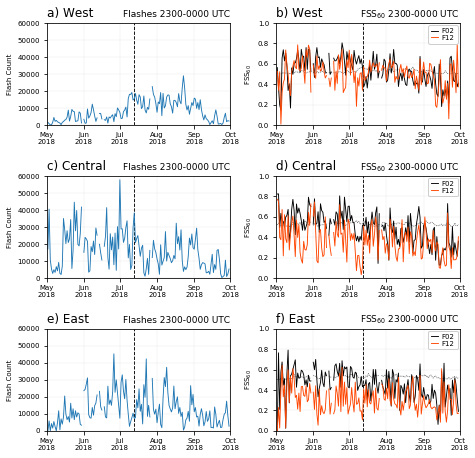

In [196]:
#domains = ['HRRR', 'West', 'Central', 'East']
domains = ['West', 'Central', 'East']
labels = [('a)', 'b)'), ('c)', 'd)'),('e)', 'f)'),('g)', 'h)')]
HOUR = 0
MONTHS = range(5,10)
radii = [20]


fig, axes = plt.subplots(3,2)    
print('Radius r%s = %s km' % (radii, np.array(radii)*3))
FSS_all = get_FSS_by_hour(HOUR, MONTHS=MONTHS, radius=radii)
Table_all = get_contingency_table_by_hour(HOUR, MONTHS=MONTHS)

for ax, DOMAIN, label in zip(axes, domains, labels):
    print()
    #ax[0].set_title('%s %s' % (label,DOMAIN), loc='left',
    #                fontweight='bold', fontsize=12,
    #                position=(-.12,1))
    ax[0].set_title('%s %s' % (label[0], DOMAIN), loc='left', fontsize=12)
    ax[1].set_title('%s %s' % (label[1],DOMAIN), loc='left', fontsize=12)
        
    ax[0].set_title('Flashes 2300-0000 UTC', loc='right', fontsize=9)
    ax[1].set_title('FSS$\mathregular{_{%s}}$ 2300-0000 UTC' % (radii[0]*3), loc='right', fontsize=9)

    flashes, DATES_flashes = plot_flash_count(ax[0], HOUR=HOUR, MONTHS=MONTHS)
    FXX_ts, DATES = plot_add_FSS_TS(ax[1], fxxs=[2,12], radii=radii, MONTHS=MONTHS)
    #FSS_fxx_ts, DATES = plot_add_FSS_TS(ax[2], fxxs=[12], radii=radii, MONTHS=MONTHS)
    
    idx_max_flashes = np.where(flashes==np.nanmax(flashes))[0][0]
    print('%s Max: %s   DATE: %s' % (DOMAIN, flashes[idx_max_flashes], DATES[idx_max_flashes]))
    print('F02: %s' % FXX_ts[0][idx_max_flashes])
    print('F12: %s' % FXX_ts[1][idx_max_flashes])
    
    ax[0].set_ylabel("Flash Count")
    ax[1].set_ylabel(r'FSS$\mathregular{_{%s}}$' % (radii[0]*3))
    
    plot_add_HRRR_version_line(ax[0], text=False)
    plot_add_HRRR_version_line(ax[1], text=False)
    #plot_add_HRRR_version_line(ax[2], text=False)

    
    for i, a in enumerate(ax):
        if i == 0:
            if DOMAIN=='HRRR':
                ymax = 80000
            else:
                ymax = 60000
            #a.fill_between([datetime(2018, 6, 1), datetime(2018, 9, 1)], 0, ymax,
            #               alpha=.15, color='grey')  #Period of hovmollers
            a.set_ylim(0,ymax)
        if i != 0:
            #a.fill_between([datetime(2018, 6, 1), datetime(2018, 9, 1)], 0, 1,
            #               alpha=.15, color='grey')  #Period of hovmollers
            a.set_ylim(0,1)
        
        a.set_xlim([datetime(2018, 5, 1), datetime(2018, 10, 1)])
        
        formatter = DateFormatter('%b\n%Y')
        a.xaxis.set_major_formatter(formatter)
        a.xaxis.set_major_locator(mdates.DayLocator([1]))
        a.grid(zorder=0)
    
    
#fig.tight_layout()
fig.subplots_adjust(wspace=.25, hspace=.5)

plt.savefig('./figs/Fig-09_Timeseries_Count-FSS')

In [395]:
idx_max_flashes[0][0]

56

In [56]:
# Missing days June-July
flashes, DATES = get_flash_count_by_hour(DOMAIN, HOUR, MONTHS=range(6,9), year=2018)
print('Missing GLM days June-July:', sum(np.isnan(flashes)))
missingDATES = np.array([DATES[i[0]] for i in np.argwhere(np.isnan(flashes))])
print(missingDATES)

print()

# Missing days May-Sep
flashes, DATES = get_flash_count_by_hour(DOMAIN, HOUR, MONTHS=range(5,10), year=2018)
print('Missing GLM days May-Sept:', sum(np.isnan(flashes)))
missingDATES = np.array([DATES[i[0]] for i in np.argwhere(np.isnan(flashes))])
print(missingDATES)

Missing GLM days June-July: 3
[datetime.datetime(2018, 6, 13, 0, 0) datetime.datetime(2018, 6, 17, 0, 0)
 datetime.datetime(2018, 7, 27, 0, 0)]

Missing GLM days May-Sept: 5
[datetime.datetime(2018, 5, 1, 0, 0) datetime.datetime(2018, 5, 31, 0, 0)
 datetime.datetime(2018, 6, 13, 0, 0) datetime.datetime(2018, 6, 17, 0, 0)
 datetime.datetime(2018, 7, 27, 0, 0)]


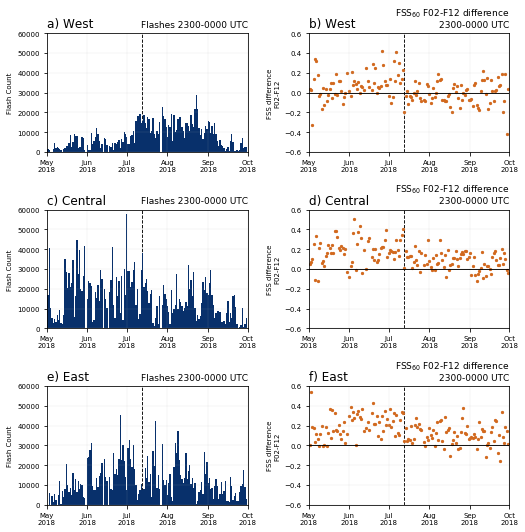

In [201]:
FSS_all = get_FSS_by_hour(HOUR, MONTHS=MONTHS, radius=r)

labels = [('a)', 'b)'), ('c)', 'd)'),('e)', 'f)'),('g)', 'h)')]

fig, axes = plt.subplots(3,2)

for ax, DOMAIN, label in zip(axes, ['West', 'Central', 'East'], labels):
    
    flashes, DATES_flashes = plot_flash_count(ax[0], HOUR=HOUR, MONTHS=MONTHS, bar=True)
    
    ax[0].set_ylabel("Flash Count")
    
    ax[0].set_title('%s %s' % (label[0], DOMAIN), loc='left', fontsize=12)
    ax[1].set_title('%s %s' % (label[1],DOMAIN), loc='left', fontsize=12)
        
    ax[0].set_title('Flashes 2300-0000 UTC', loc='right', fontsize=9)
    ax[1].set_title('FSS$\mathregular{_{%s}}$ F02-F12 difference\n2300-0000 UTC' % (radii[0]*3), loc='right', fontsize=9)
    
    FSS_f02 = np.array([i[2] for m in range(5,10) for i in FSS_all[DOMAIN][m]])
    FSS_f12 = np.array([i[12] for m in range(5,10) for i in FSS_all[DOMAIN][m]])
    
    FSS_D = np.array([i[0] for m in range(5,10) for i in FSS_all[DOMAIN][m]])
    DATES = np.array([])
    for D in FSS_D:
        try:
            DATES = np.append(DATES, datetime.strptime(D, '%Y-%m-%d %H:%M:%S'))
        except:
            DATES = np.append(DATES, datetime.strptime(D, '%m/%d/%Y %H:%M'))
    
    plt.sca(ax[1])
    plt.scatter(DATES, FSS_f02-FSS_f12, s=5, color='chocolate')
    plt.axhline(0, linestyle='-', color='k')
    plt.ylabel('FSS difference\nF02-F12')
    
    
    plot_add_HRRR_version_line(ax[0], text=False)
    plot_add_HRRR_version_line(ax[1], text=False)
    
    for i, a in enumerate(ax):
        if i == 0:
            if DOMAIN=='HRRR':
                ymax = 80000
            else:
                ymax = 60000
            #a.fill_between([datetime(2018, 6, 1), datetime(2018, 9, 1)], 0, ymax,
            #               alpha=.15, color='grey')  #Period of hovmollers
            a.set_ylim(0,ymax)
        if i != 0:
            #a.fill_between([datetime(2018, 6, 1), datetime(2018, 9, 1)], 0, 1,
            #               alpha=.15, color='grey')  #Period of hovmollers
            a.set_ylim(-.6,.6)
        
        a.set_xlim([datetime(2018, 5, 1), datetime(2018, 10, 1)])
        
        formatter = DateFormatter('%b\n%Y')
        a.xaxis.set_major_formatter(formatter)
        a.xaxis.set_major_locator(mdates.DayLocator([1]))
        a.grid(zorder=0)
    
fig.tight_layout()

plt.savefig('./figs/Fig-06_Flash_FSS_2300-0000_UTC')

<BarContainer object of 153 artists>

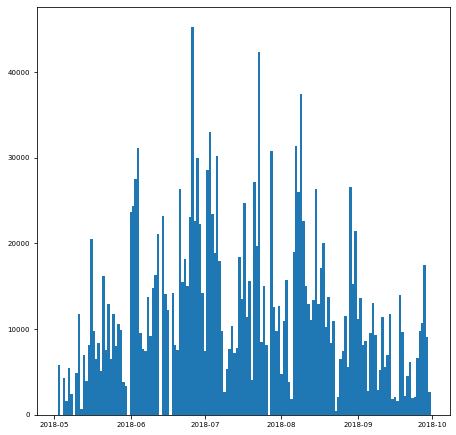

In [194]:
plt.bar(DATES,flashes, width=1)

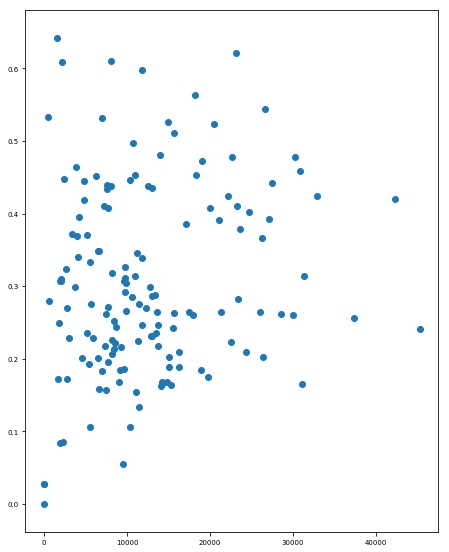

In [333]:
plt.scatter(flashes,FSS_fxx_ts)

In [60]:
FSS_all = get_FSS_by_hour(HOUR, MONTHS=MONTHS, radius=radii)

In [65]:
FSS_all

{'West': {5: array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan]),
  6: array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan]),
  7: array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan]),
  8: array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan]),
  9: array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan])},
 'Central': {5: array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan]),
  6: array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan]),
  7: array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan]),
  8: array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,

In [309]:
for i, D in enumerate(DATES_flashes):
    print(i, D, DATES[i])

0 2018-05-01 00:00:00 2018-05-01 00:00:00
1 2018-05-02 00:00:00 2018-05-02 00:00:00
2 2018-05-03 00:00:00 2018-05-03 00:00:00
3 2018-05-04 00:00:00 2018-05-04 00:00:00
4 2018-05-05 00:00:00 2018-05-05 00:00:00
5 2018-05-06 00:00:00 2018-05-06 00:00:00
6 2018-05-07 00:00:00 2018-05-07 00:00:00
7 2018-05-08 00:00:00 2018-05-08 00:00:00
8 2018-05-09 00:00:00 2018-05-09 00:00:00
9 2018-05-10 00:00:00 2018-05-10 00:00:00
10 2018-05-11 00:00:00 2018-05-11 00:00:00
11 2018-05-12 00:00:00 2018-05-12 00:00:00
12 2018-05-13 00:00:00 2018-05-13 00:00:00
13 2018-05-14 00:00:00 2018-05-14 00:00:00
14 2018-05-15 00:00:00 2018-05-15 00:00:00
15 2018-05-16 00:00:00 2018-05-16 00:00:00
16 2018-05-17 00:00:00 2018-05-17 00:00:00
17 2018-05-18 00:00:00 2018-05-18 00:00:00
18 2018-05-19 00:00:00 2018-05-19 00:00:00
19 2018-05-20 00:00:00 2018-05-20 00:00:00
20 2018-05-21 00:00:00 2018-05-21 00:00:00
21 2018-05-22 00:00:00 2018-05-22 00:00:00
22 2018-05-23 00:00:00 2018-05-23 00:00:00
23 2018-05-24 00:00:0

IndexError: index 153 is out of bounds for axis 0 with size 153

Radius r[20] = [60] km
Radius r[20] = [60] km
Radius r[20] = [60] km
Radius r[20] = [60] km
Radius r[20] = [60] km
Radius r[20] = [60] km


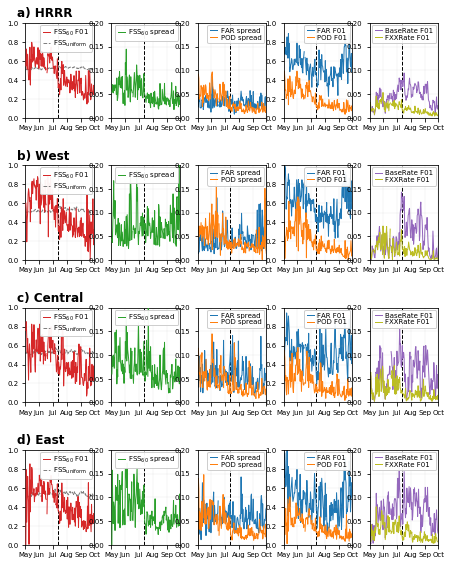

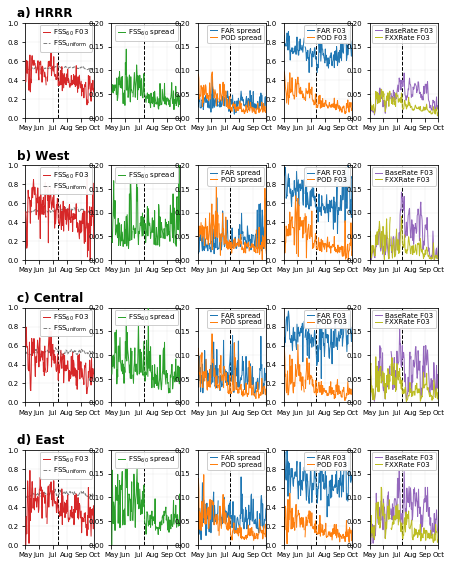

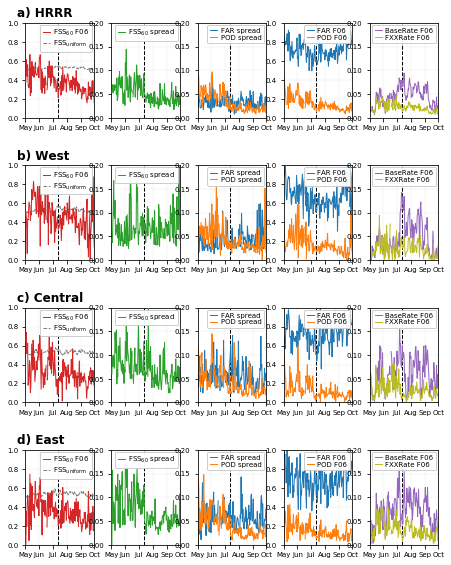

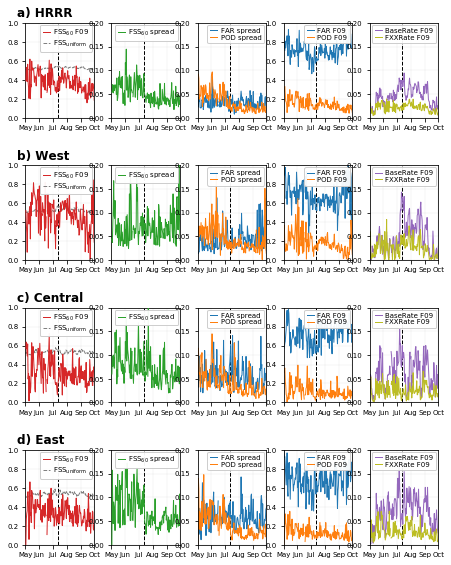

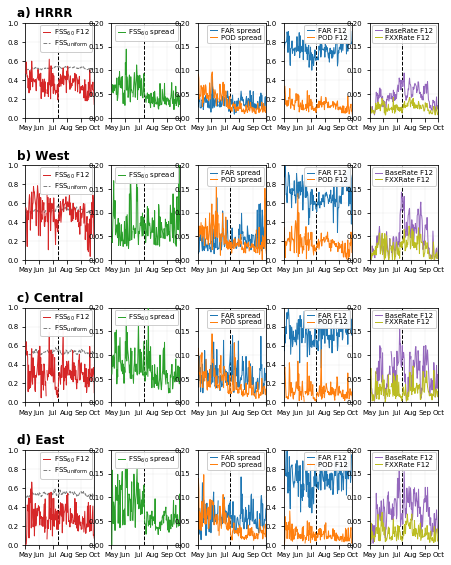

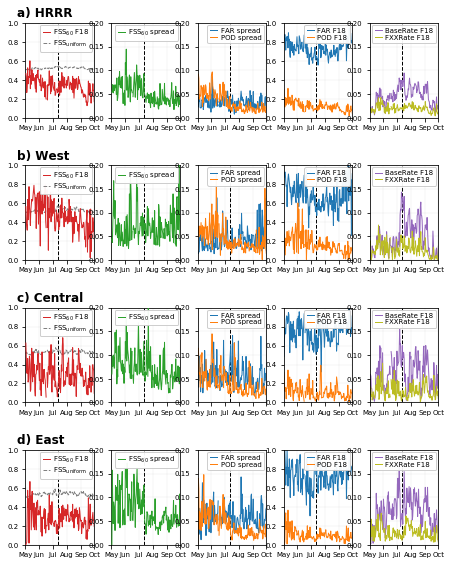

In [166]:
domains = ['HRRR', 'West', 'Central', 'East']
labels = ['a)', 'b)', 'c)', 'd)']
HOUR = 22
MONTHS = range(5,10)
radii = [20]

for fxx in [1, 3, 6, 9, 12, 18]:
    fig, axes = plt.subplots(4,5)    
    print('Radius r%s = %s km' % (radii, np.array(radii)*3))
    FSS_all = get_FSS_by_hour(HOUR, MONTHS=MONTHS, radius=radii)
    Table_all = get_contingency_table_by_hour(HOUR, MONTHS=MONTHS)

    for ax, DOMAIN, label in zip(axes, domains, labels):
        ax[0].set_title('%s %s' % (label,DOMAIN), loc='left',
                        fontweight='bold', fontsize=12,
                        position=(-.12,1))

        plot_add_FSS_TS(ax[0], fxx=fxx, radii=radii)
        plot_add_FSS_spred(ax[1], radii=radii, fxxs=range(3,19))
        plot_add_POD_FAR_spred(ax[2], fxxs=range(3,19))
        plot_add_POD_FAR(ax[3], fxx=fxx)
        plot_add_BaseFXXRates(ax[4], fxx=fxx)


        plot_add_HRRR_version_line(ax[0], text=False)
        plot_add_HRRR_version_line(ax[1], text=False)
        plot_add_HRRR_version_line(ax[2], text=False)
        plot_add_HRRR_version_line(ax[3], text=False)
        plot_add_HRRR_version_line(ax[4], text=False)

        for i, a in enumerate(ax):
            a.set_xlim([datetime(2018, 5, 1), datetime(2018, 10, 1)])
            if i == 0 or i == 3:
                a.set_ylim([0,1])
            else:
                a.set_ylim([0,.2])
            formatter = DateFormatter('%b')
            a.xaxis.set_major_formatter(formatter)
            a.xaxis.set_major_locator(mdates.DayLocator([1]))
            a.grid(zorder=0)

    #fig.tight_layout()
    fig.subplots_adjust(wspace=.25, hspace=.5)

    plt.savefig('./figs/not-shown_Score-Spread-Timesereis_h%02d_f%02d' % (HOUR, fxx))

---
#### Print Average Scores between HRRRv2 and HRRRv3

In [136]:
fxx = 6
radii = [20]
for r in radii:
    FSS_all = get_FSS_by_hour(HOUR, MONTHS=MONTHS, radius=r)
    FSS_fxx_ts = []
    ABCD_ts = {'A':[],
               'B':[],
               'C':[],
               'D':[]}
    dates = []
    for m in MONTHS:
        FSS = FSS_all[DOMAIN][m]['F%02d_FSS' % fxx]
        FSS_fxx_ts = list(FSS_fxx_ts) + list(FSS)

        for i in ['A', 'B', 'C', 'D']:
            ABCD = Table_all[DOMAIN][m]['F%02d_%s' % (fxx, i)]
            ABCD_ts[i] = list(ABCD_ts[i]) + list(ABCD)

POD_ts = hit_rate(np.array(ABCD_ts['A']), np.array(ABCD_ts['B']), np.array(ABCD_ts['C']), np.array(ABCD_ts['D']))
FAR_ts = false_alarm_ratio(np.array(ABCD_ts['A']), np.array(ABCD_ts['B']), np.array(ABCD_ts['C']), np.array(ABCD_ts['D']))
FxxRate_ts = forecast_rate(np.array(ABCD_ts['A']), np.array(ABCD_ts['B']), np.array(ABCD_ts['C']), np.array(ABCD_ts['D']))
BaseRate_ts = base_rate(np.array(ABCD_ts['A']), np.array(ABCD_ts['B']), np.array(ABCD_ts['C']), np.array(ABCD_ts['D']))

In [137]:
idx_change = np.where(DATES==datetime(2018, 7, 12, 22, 0))

In [138]:
idx_change

(array([72]),)

In [139]:
idx_v2 = slice(0,idx_change[0][0])
idx_v3 = slice(idx_change[0][0], idx_change[0][0]+len(DATES[idx_v2]))

In [161]:
print('Hour: %02d\tFXX:%02d' % (HOUR, fxx))
print('Change in mean metrics after the model upgrade: based on %s days before and after the date change' % idx_change[0][0])
print('{:^10}|{:^10}|{:^10}|{:^10}|'.format('', 'HRRRv2', 'HRRRv3', 'Delta'))
for i, name in zip([FSS_fxx_ts, POD_ts, FAR_ts, BaseRate_ts, FxxRate_ts], ['FSS', 'POD', 'FAR', 'BaseRate', 'FXXRate']):
    v2 = np.nanmean(i[idx_v2])
    v3 = np.nanmean(i[idx_v3])
    delta = v3-v2
    print('{:^10}|{:^10.3f}|{:^10.3f}|{:^10.3f}|'.format(name, v2, v3, delta))

Hour: 22	FXX:06
Change in mean metrics after the model upgrade: based on 72 days before and after the date change
          |  HRRRv2  |  HRRRv3  |  Delta   |
   FSS    |  0.438   |  0.328   |  -0.110  |
   POD    |  0.204   |  0.109   |  -0.095  |
   FAR    |  0.715   |  0.700   |  -0.015  |
 BaseRate |  0.041   |  0.053   |  0.012   |
 FXXRate  |  0.027   |  0.019   |  -0.008  |


In [426]:
DOMAIN = 'West'

In [427]:
Table_all = get_contingency_table_by_hour(HOUR=0, MONTHS=range(5,11))

In [428]:
aa, bb = plot_add_FSS_TS(ax, [2, 12], [20], MONTHS=range(5,11), legend=False, plot=False)

West FSSuniform max and min: 0.5701670198864572 0.5


In [429]:
np.where(bb==datetime(2018,8,3))

(array([94]),)

In [434]:
for i in range(90,101):
    print(bb[i])
    print('F02:', aa[0][i])
    print('F12:', aa[1][i])

2018-07-30 00:00:00
F02: 0.6464
F12: 0.5599
2018-07-31 00:00:00
F02: 0.6261
F12: 0.5591
2018-08-01 00:00:00
F02: 0.4211
F12: 0.4321
2018-08-02 00:00:00
F02: 0.4396
F12: 0.5441
2018-08-03 00:00:00
F02: 0.543
F12: 0.6019
2018-08-04 00:00:00
F02: 0.6995
F12: 0.6489
2018-08-05 00:00:00
F02: 0.5106
F12: 0.5588
2018-08-06 00:00:00
F02: 0.5793
F12: 0.5818
2018-08-07 00:00:00
F02: 0.7414
F12: 0.6241
2018-08-08 00:00:00
F02: 0.6049
F12: 0.4186
2018-08-09 00:00:00
F02: 0.6048
F12: 0.4785


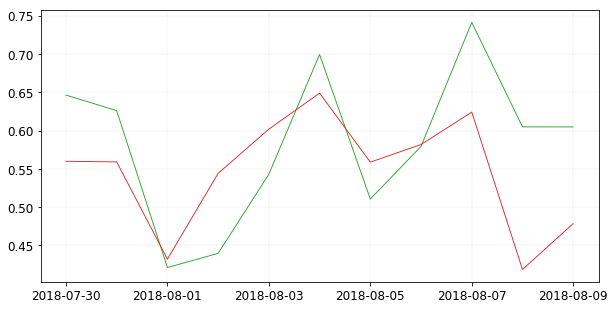

In [438]:
plt.figure(figsize=(10,5))
plt.plot(bb[90:101], aa[0][90:101], color='tab:green')
plt.plot(bb[90:101], aa[1][90:101], color='tab:red')
plt.xticks(fontsize=12);plt.yticks(fontsize=12); plt.grid()